In [210]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display

# 데이터 불러오기

In [211]:
from data_preprocess import preprocessing

In [212]:
base_path = '2022-03-07/'
file_paths = [
    base_path + 'bestshots.json', 
    base_path + 'items.json', 
    base_path +'categories.json', 
    base_path +'products.json'
]

In [213]:
products_df_4, products_df_b = preprocessing(file_paths)

/Users/ruo/Desktop/codestates/CP2/data_preprocess.py:37: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  items_stack = pd.DataFrame(templates_df['items'].apply(lambda x: pd.Series(x)).stack()).reset_index(1, drop=True)


In [214]:
products_df_4.shape, products_df_b.shape

((4211, 10), (46576, 10))

In [220]:
products_df_b.head()

,enterprise_id,top3_style,top_style,projectId,awesome_score,product_id,tags,name,images,use_count,style_literal
0,B57D4F97C0E44A11,"[NATURAL, MID_CENTURY_MODERN, MODERN]",NATURAL,X9djPepD57A2BDCD418437C,0.993074,XjDwfV4C2377DB2C32B4EBD,"[렌지대, 주방수납, 주방장, 주방선반, 베이지, 가공목(mdf외), 가공목, 나무...",onion 진저 주방 수납장 (내추럴),[https://resources.archisketch.com/product/XjD...,10,NATURAL MID_CENTURY_MODERN MODERN
1,B57D4F97C0E44A11,"[NATURAL, SCANDINAVIAN, MINIMAL]",NATURAL,X9dU4bb1CF0EE26E341493B,0.983243,XjDwfV4C2377DB2C32B4EBD,"[렌지대, 주방수납, 주방장, 주방선반, 베이지, 가공목(mdf외), 가공목, 나무...",onion 진저 주방 수납장 (내추럴),[https://resources.archisketch.com/product/XjD...,10,NATURAL SCANDINAVIAN MINIMAL
2,B57D4F97C0E44A11,"[NATURAL, KOREAN_AND_ASIAN, CLASSIC_AND_ANTIQUE]",NATURAL,X9a1taeFAA511E93B794404,0.893659,XjDwfV4C2377DB2C32B4EBD,"[렌지대, 주방수납, 주방장, 주방선반, 베이지, 가공목(mdf외), 가공목, 나무...",onion 진저 주방 수납장 (내추럴),[https://resources.archisketch.com/product/XjD...,10,NATURAL KOREAN_AND_ASIAN CLASSIC_AND_ANTIQUE
3,B57D4F97C0E44A11,"[MODERN, NATURAL, MINIMAL]",MODERN,X8Ao1yi02242EB57CD44E0B,0.839363,XjDwfV4C2377DB2C32B4EBD,"[렌지대, 주방수납, 주방장, 주방선반, 베이지, 가공목(mdf외), 가공목, 나무...",onion 진저 주방 수납장 (내추럴),[https://resources.archisketch.com/product/XjD...,10,MODERN NATURAL MINIMAL
4,B57D4F97C0E44A11,"[NATURAL, MODERN, MID_CENTURY_MODERN]",NATURAL,X8MtJveB527ACDC1FE44F66,0.981309,XjDwfV4C2377DB2C32B4EBD,"[렌지대, 주방수납, 주방장, 주방선반, 베이지, 가공목(mdf외), 가공목, 나무...",onion 진저 주방 수납장 (내추럴),[https://resources.archisketch.com/product/XjD...,10,NATURAL MODERN MID_CENTURY_MODERN


# Style 콘텐츠 유사도 측정

In [216]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [217]:
products_df_4['style_literal'] = products_df_4['top3_style'].apply(lambda x: ' '.join(x))
products_df_b['style_literal'] = products_df_b['top3_style'].apply(lambda x: ' '.join(x))

### 코사인 유사도를 통해 스타일 별 유사도 행렬 구하기

In [218]:
def get_style_matrix(df):
    count_vect = CountVectorizer(min_df=0, ngram_range=(1, 2))
    style_mat = count_vect.fit_transform(df['style_literal'])
    return style_mat

# 유사도가 높은 순으로 style_sim 비교 행 위치 인덱스 구하기
def get_sim_sorted_ind(df):
    mat = get_style_matrix(df)
    style_sim = cosine_similarity(mat, mat)
    style_sim_sorted_ind = style_sim.argsort()[:, ::-1]
    return style_sim_sorted_ind

In [221]:
style_sim_sorted_ind_4 = get_sim_sorted_ind(products_df_4)
style_sim_sorted_ind_b = get_sim_sorted_ind(products_df_b)

style_sim_sorted_ind_4.shape, style_sim_sorted_ind_b.shape

((4211, 4211), (46576, 46576))

### 스타일 콘텐츠 필터링을 이용한 상품 추천

In [222]:
def find_sim_item(df, sorted_ind, item_name, top_n=10):
    item_chosen = df[df['name'] == item_name]
    
    item_index = item_chosen.index.values
    similar_indices = sorted_ind[item_index, :(top_n*2)]
    similar_indices = similar_indices.reshape(-1)
    if similar_indices.ndim > 1:
        similar_indices = similar_indices.reshape(-1)
    
    # print(item_index)
    # print(similar_indices.shape, similar_indices)

    similar_indices = np.setdiff1d(similar_indices, item_index)

    # awesome_score 와 use_count 순서대로 높은 결과로 sorting
    cols = ['top_style', 'projectId', 'name', 'use_count', 'awesome_score', 'tags', 'images', 'product_id']
    recc_result = df.iloc[similar_indices].sort_values(by=['awesome_score', 'use_count'], ascending=False)[:top_n][cols]
    
    item_image_res = requests.get(df.iloc[item_index]['images'].tolist()[0][0])
    display(Image.open(BytesIO(item_image_res.content)))
    print(f'[{item_name}]에 대한 Top{top_n} 추천 결과')
    print('='*80)
    
    for i, (recc_image, recc_item) in enumerate(zip(recc_result['images'].tolist(), recc_result['name'].tolist())):
        try:
            res = requests.get(recc_image[0])
            img = Image.open(BytesIO(res.content))
            display(img)
        except IndexError:
            print('이미지가 없습니다!')
        
        print(f'{i+1}순위 추천 아이템 : {recc_item}')
        print('-'*60)
    print('='*80)
                                                
    return recc_result

### 'B57D4F97C0E44A11' 에 대한 추천 테스트

In [223]:
products_df_b['name'][:5]

0    onion 진저 주방 수납장 (내추럴)
1    onion 진저 주방 수납장 (내추럴)
2    onion 진저 주방 수납장 (내추럴)
3    onion 진저 주방 수납장 (내추럴)
4    onion 진저 주방 수납장 (내추럴)
Name: name, dtype: object

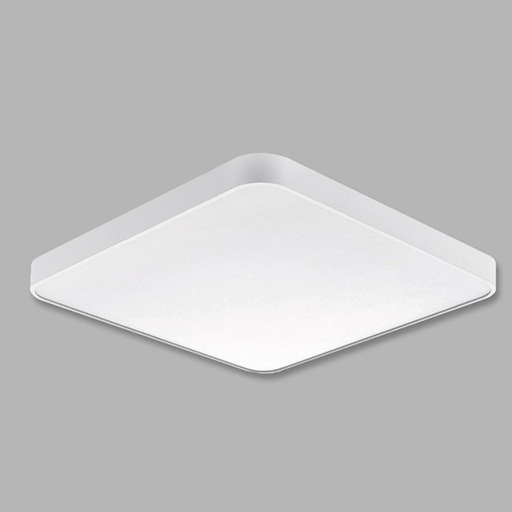

[화이트 정사각 LED 방등 화이트]에 대한 Top10 추천 결과
이미지가 없습니다!
1순위 추천 아이템 : Archisketch Latte Cup
------------------------------------------------------------
이미지가 없습니다!
2순위 추천 아이템 : Archisketch Plants G
------------------------------------------------------------


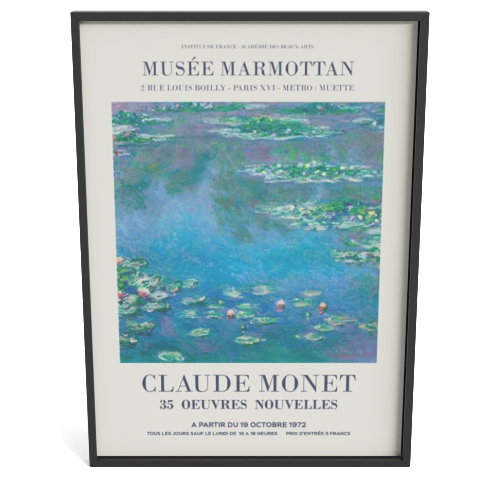

3순위 추천 아이템 : 명화 빈티지 전시회 포스터 - 모네 수련 1906 (50X70) 블랙
------------------------------------------------------------


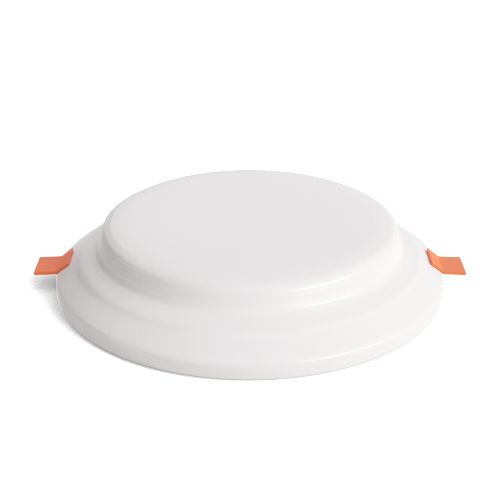

4순위 추천 아이템 : LED 다운라이트 4인치 7W 매입등 (전구색)
------------------------------------------------------------
이미지가 없습니다!
5순위 추천 아이템 : Archisketch Kitchen Deco
------------------------------------------------------------


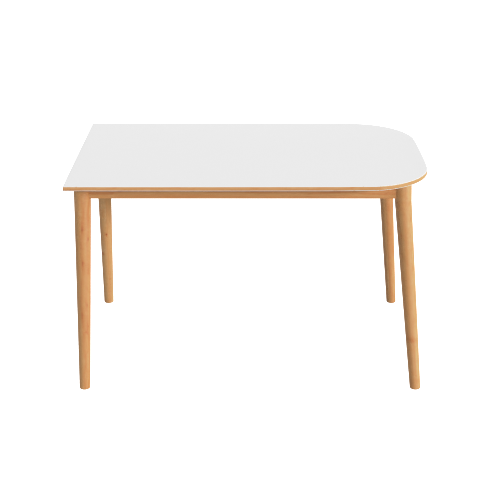

6순위 추천 아이템 : 모아 1200 고무나무 원목 반타원 화이트 식탁 테이블 단품 (화이트)
------------------------------------------------------------


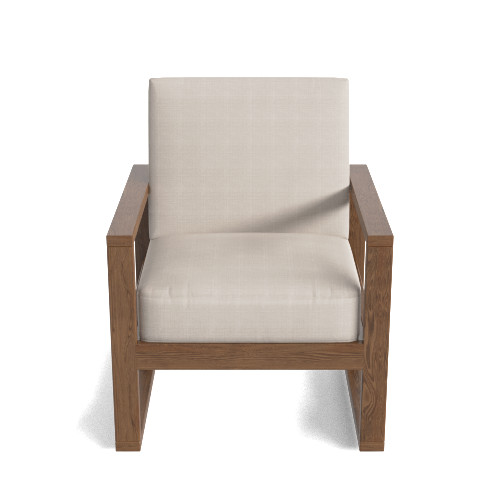

7순위 추천 아이템 : ETAN 1인소파 (월넛/베이지)
------------------------------------------------------------


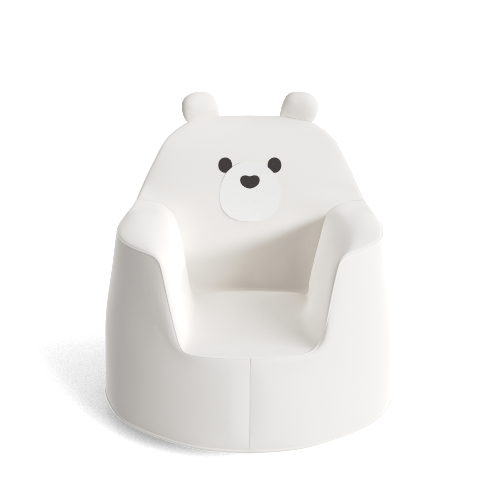

8순위 추천 아이템 : 폴라아코 유아동소파(아이보리)
------------------------------------------------------------
이미지가 없습니다!
9순위 추천 아이템 : Archisketch Childrens Table
------------------------------------------------------------


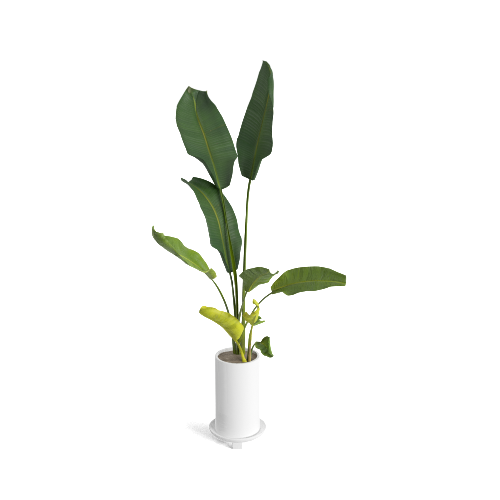

10순위 추천 아이템 : 여인초 대형 테라조 화분세트 (2촉)
------------------------------------------------------------


,top_style,projectId,name,use_count,awesome_score,tags,images,product_id
2009,NATURAL,X8W_69HBB9C8BD301A94CD9,Archisketch Latte Cup,316,0.996008,[],[],DE8694FACFFB4045
19395,NATURAL,X8W_69HBB9C8BD301A94CD9,Archisketch Plants G,41,0.996008,[],[],B1451F5F3C884330
38561,NATURAL,X8W_69HBB9C8BD301A94CD9,명화 빈티지 전시회 포스터 - 모네 수련 1906 (50X70) 블랙,2,0.996008,"[홈갤러리, 갤러리, 미술품, 미술, 예술품, 그림, 페인팅, 블루, 파랑, 파란,...",[https://resources.archisketch.com/product/XX4...,XX45msQC6B0B387052B4D7E
16881,MODERN,X8nOJBP70A4670CF22F4BF6,LED 다운라이트 4인치 7W 매입등 (전구색),81,0.995537,"[조명, LED조명, LED, 화이트, 흰색, 하얀색, 매입등, 매입, 공간LED]",[https://resources.archisketch.com/product/XkM...,XkM8Wtp650F56126DB542B5
2758,NATURAL,X3mUAD2BE63596E56CB41A5,Archisketch Kitchen Deco,75,0.993945,[],[],B93D7CFCE0714CC6
38084,MODERN,X7JGA7MCD24546E34634CA5,모아 1200 고무나무 원목 반타원 화이트 식탁 테이블 단품 (화이트),10,0.990722,"[테이블, 태이블, 탁자, 식탁, 다이닝테이블, 다이닝식탁, 식탁테이블, 화이트, ...",[https://resources.archisketch.com/product/Xs_...,Xs_QLXW0EA9DDE6C3EF46D8
46086,MODERN,XxOpq9bB9DBBD34D65247C3,ETAN 1인소파 (월넛/베이지),1,0.990349,"[소파, 쇼파, 1인용소파, 1인소파, 1인쇼파, 1인, 1인용, 1인용쇼파, 베이...",[https://resources.archisketch.com/product/Xdm...,XdmFHsy01FDCC2388634BC6
46087,MODERN,XxOpq9bB9DBBD34D65247C3,폴라아코 유아동소파(아이보리),1,0.990349,"[유아동소파, 유아, 키즈, 아기, 아동, 소파, 아기소파, 화이트, 흰색, 일룸]",[https://resources.archisketch.com/product/XuB...,XuBocUD850B8617CBE24147
46088,MODERN,XxOpq9bB9DBBD34D65247C3,Archisketch Childrens Table,1,0.990349,[],[],5A709E4E70574061
521,MODERN,X4UKU4KFB6E89D94DF04733,여인초 대형 테라조 화분세트 (2촉),137,0.989862,"[플라워/식물, 플라워, 식물, 플랜트, 플랜테리어, 플렌트, 식물데코, 식물인테리...",[https://resources.archisketch.com/product/88F...,88FFE54853614272


In [227]:
search_item = '화이트 정사각 LED 방등 화이트'
find_sim_item(products_df_b, style_sim_sorted_ind_b, search_item, 10)

### '421B6D0E746C4E6D' 에 대한 추천 테스트

In [225]:
products_df_4['name'].tolist()[:10]

['화이트 쉬폰 커튼 화이트',
 '화이트 쉬폰 커튼 화이트',
 '특대형 아레카야자 흰색 데코 화분 (화이트)',
 '여인초 대형 테라조 화분세트 (2촉)',
 '여인초 대형 테라조 화분세트 (2촉)',
 '맞춤 차르르 차로롬커튼/쉬폰/나비주름',
 '튤립 조화(10P) 화병 세트 옐로우',
 '무이 1등 장스탠드(LED 전구포함) (화이트)',
 '몬스테라_우드 스탠드화분(중)',
 '몬스테라_우드 스탠드화분(중)']

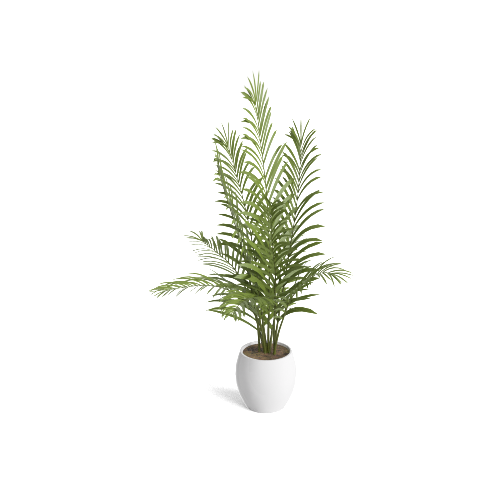

[특대형 아레카야자 흰색 데코 화분 (화이트)]에 대한 Top10 추천 결과


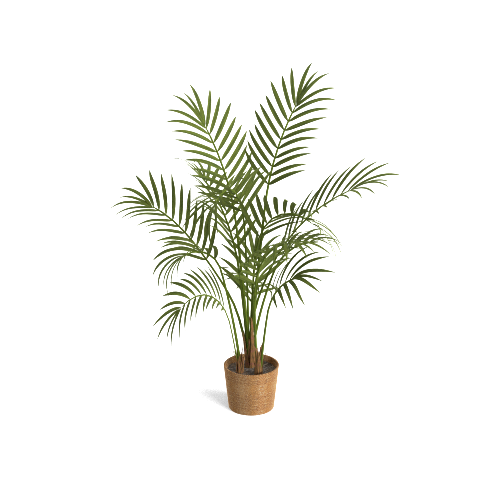

1순위 추천 아이템 : 식물1
------------------------------------------------------------


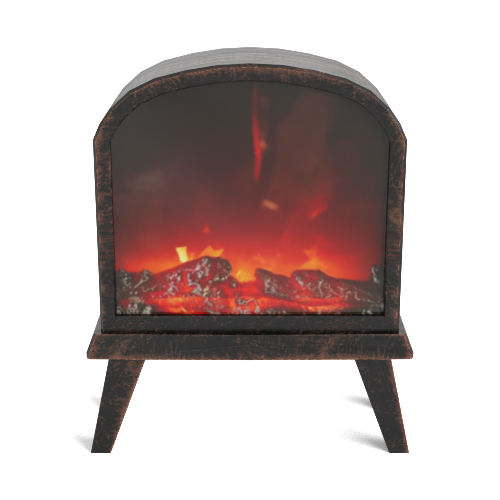

2순위 추천 아이템 : 우리집 속 불멍 벽난로 무드등
------------------------------------------------------------


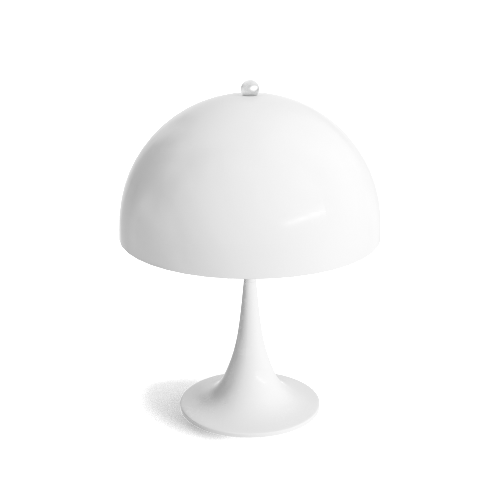

3순위 추천 아이템 : 오팔 단스탠드 (화이트)
------------------------------------------------------------


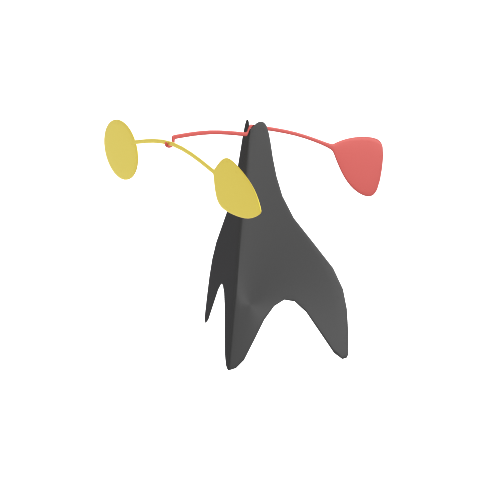

4순위 추천 아이템 : 데스크탑 스탠딩 모빌 desktop mobile (red & yellow)
------------------------------------------------------------
이미지가 없습니다!
5순위 추천 아이템 : Archisketch Ceiling Square_on
------------------------------------------------------------


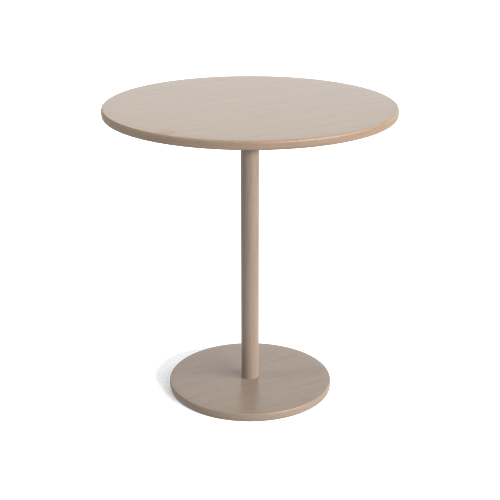

6순위 추천 아이템 : 원형 테이블 700 (자작나무) (자작나무)
------------------------------------------------------------


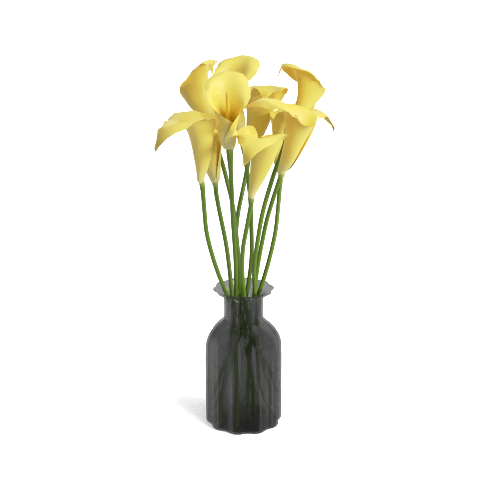

7순위 추천 아이템 : 카라 조화 (Yellow)
------------------------------------------------------------
이미지가 없습니다!
8순위 추천 아이템 : 컴패스 모듈형 3인소파 (302)
------------------------------------------------------------


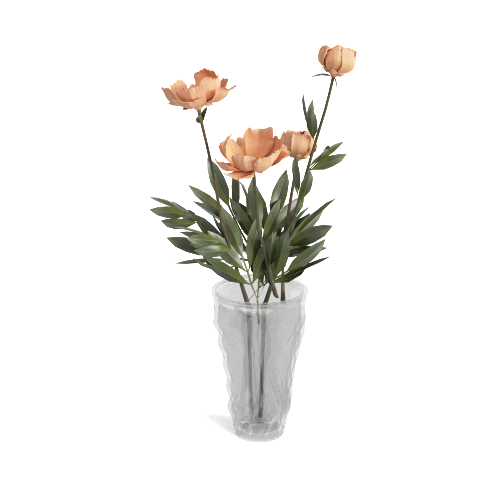

9순위 추천 아이템 : 양귀비 가지 조화 (피치코랄)
------------------------------------------------------------


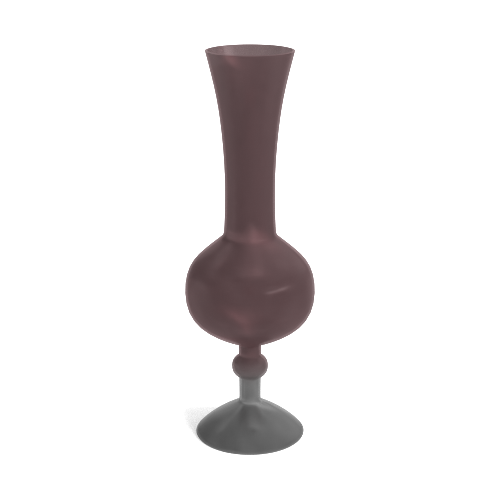

10순위 추천 아이템 : 엘렌 제이드 꽃병(다크로즈)
------------------------------------------------------------


,top_style,projectId,name,use_count,awesome_score,tags,images,product_id
1506,MODERN,X6P3Xt_A455473756414B85,식물1,5,0.991763,"[식물, 화분]",[https://resources.archisketch.com/product/XjU...,XjUJgjODC8022AFC9994BAD
1011,MODERN,X5WaEry9CEC543A4961492E,우리집 속 불멍 벽난로 무드등,28,0.987451,"[조명, 무드등/장식조명, 무드등, 무드, 브라운, 갈색, 무드등/수면등, 무드등,...",[https://resources.archisketch.com/product/XYW...,XYW9sOc9CC9CD1261C74F5E
1485,MODERN,X5WaEry9CEC543A4961492E,오팔 단스탠드 (화이트),26,0.987451,[제일조명],[https://resources.archisketch.com/product/XvJ...,XvJtJXCEC55AD1837E44E90
358,MODERN,X5WaEry9CEC543A4961492E,데스크탑 스탠딩 모빌 desktop mobile (red & yellow),22,0.987451,[Ekko Workshop(에코워크샵)],[https://resources.archisketch.com/product/Xz-...,Xz-wAFU341B23F88AC24255
1523,MODERN,X5WaEry9CEC543A4961492E,Archisketch Ceiling Square_on,12,0.987451,[],[],FB9EA7E54E064C80
3725,MODERN,X5WaEry9CEC543A4961492E,원형 테이블 700 (자작나무) (자작나무),2,0.987451,"[테이블, 태이블, 탁자, 식탁, 다이닝테이블, 다이닝식탁, 식탁테이블, 화이트, ...",[https://resources.archisketch.com/product/XkM...,XkM8XgRDE9EEA1518A84D98
3729,MODERN,X5WaEry9CEC543A4961492E,카라 조화 (Yellow),2,0.987451,[],[https://resources.archisketch.com/product/Xho...,Xhotk-V1C66B75924EF4164
3727,MODERN,X5WaEry9CEC543A4961492E,컴패스 모듈형 3인소파 (302),1,0.987451,"[키코디자인, kikodesign, 소파, 3인용, 모듈가구, 모듈소파]",[],XjEizgX2E9A411F83144752
3728,MODERN,X5WaEry9CEC543A4961492E,양귀비 가지 조화 (피치코랄),1,0.987451,[],[https://resources.archisketch.com/product/Xho...,XhowMbS8E4574718A6C452A
3731,MODERN,X5WaEry9CEC543A4961492E,엘렌 제이드 꽃병(다크로즈),1,0.987451,"[페이퍼가든, PAPER GARDEN, 꽃병, 유리병, 화병, 인테리어소품, 투명유리]",[https://resources.archisketch.com/product/Xl9...,Xl916ZEF5AE5286812C4D70


In [226]:
find_sim_item(products_df_4, style_sim_sorted_ind_4, '특대형 아레카야자 흰색 데코 화분 (화이트)', 10)